# Basin-level Descriptive Analysis


In [1]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import data from csv file
innercore_data = pl.read_csv("../data_pipeline/innercore_timebin_joined.csv")
innercore_data = innercore_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"),
    pl.col("lightning_count").log1p().alias("log_lightning_count"),
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
innercore_data.head()

time_bin,storm_code,lightning_count,year,month,day,hour,minute,lat,lon,pressure,knots,storm_name,category,basin,minute_right,24_hour_knots_diff,24_hour_pressure_diff,TC_Category,Intensification_Category,log_lightning_count
datetime[μs],str,i64,i64,i64,i64,i64,i64,f64,f64,i64,i64,str,i64,str,i64,f64,f64,str,str,f64
2010-06-21 07:00:00,"""ATL_10_1""",1,2010,6,21,7,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.693147
2010-06-21 07:30:00,"""ATL_10_1""",0,2010,6,21,7,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0
2010-06-21 08:00:00,"""ATL_10_1""",0,2010,6,21,8,0,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0
2010-06-21 08:30:00,"""ATL_10_1""",0,2010,6,21,8,30,13.4,-66.5,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0
2010-06-21 09:00:00,"""ATL_10_1""",0,2010,6,21,9,0,14.0,-67.6,1011,20,"""Alex""",2,"""ATL""",0,5.0,-1.0,"""Unidentified""","""Neutral""",0.0


In [3]:
# number of storms per basin
innercore_data.group_by("basin").agg(pl.struct("storm_code").n_unique().alias("unique_tc_count"))

basin,unique_tc_count
str,u32
"""SHEM""",127
"""CPAC""",7
"""EPAC""",82
"""IO""",26
"""WPAC""",146
"""ATL""",84


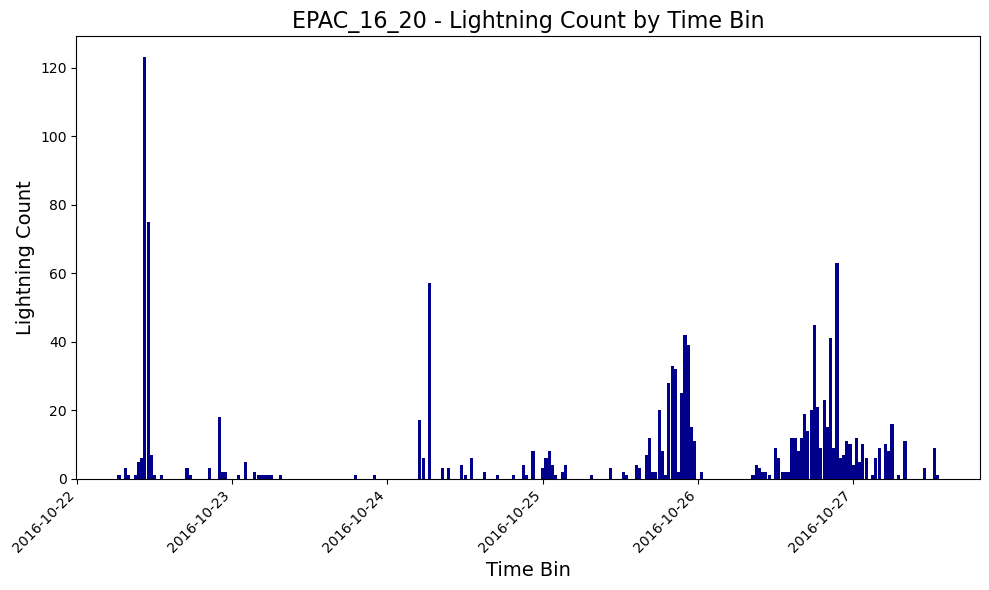

In [4]:
# Convert Polars DataFrame to pandas for plotting
epac_16_10 = innercore_data.filter(pl.col("storm_code") == "EPAC_16_20")
epac_16_10_pd = epac_16_10.to_pandas()

# Plot histogram (bar chart)
plt.figure(figsize=(10, 6))
plt.bar(epac_16_10_pd["time_bin"], epac_16_10_pd["lightning_count"], color="darkblue", width=0.02)

# Format plot
plt.title("EPAC_16_20 - Lightning Count by Time Bin", fontsize=16)
plt.xlabel("Time Bin", fontsize=14)
plt.ylabel("Lightning Count", fontsize=14)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

### ATL Basin

### EPAC Basin


In [5]:
epac_data = innercore_data.filter(pl.col("basin") == "EPAC")
epac_storm_codes = epac_data["storm_code"].unique()
epac_storm_codes.head()

storm_code
str
"""EPAC_20_9"""
"""EPAC_14_7"""
"""EPAC_15_12"""
"""EPAC_16_4"""
"""EPAC_12_4"""
"""EPAC_12_9"""
"""EPAC_15_19"""
"""EPAC_11_7"""
"""EPAC_12_7"""


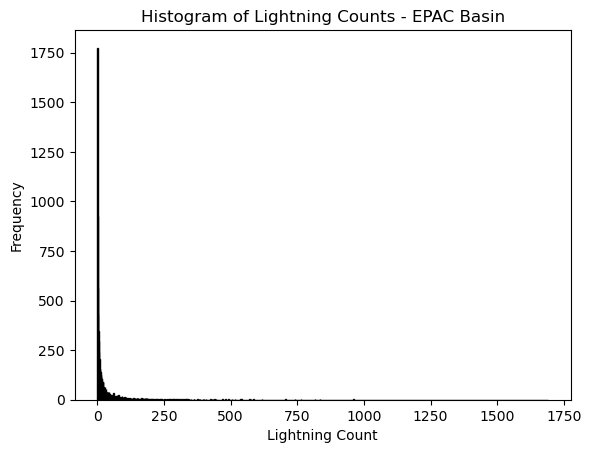

In [6]:
lightning_counts = epac_data["lightning_count"]
# Create histogram
plt.hist(lightning_counts, bins=range(1, max(lightning_counts) + 2), edgecolor="black", align="left")

# Labels and title
plt.xlabel("Lightning Count")
plt.ylabel("Frequency")
plt.title("Histogram of Lightning Counts - EPAC Basin")
plt.show()

In [10]:
epac_data_nozero = epac_data[epac_data["lightning_count"]!=0]

polars.dataframe.frame.DataFrame

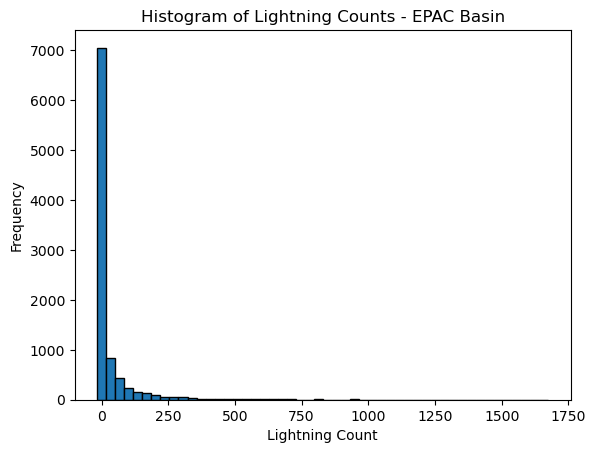

In [13]:
# Create histogram
epac_data_nozero = epac_data.filter(pl.col("lightning_count")!=0)
lightning_counts = epac_data_nozero["lightning_count"]
plt.hist(lightning_counts, bins=50, edgecolor="black", align="left")

# Labels and title
plt.xlabel("Lightning Count")
plt.ylabel("Frequency")
plt.title("Histogram of Lightning Counts - EPAC Basin")
plt.show()

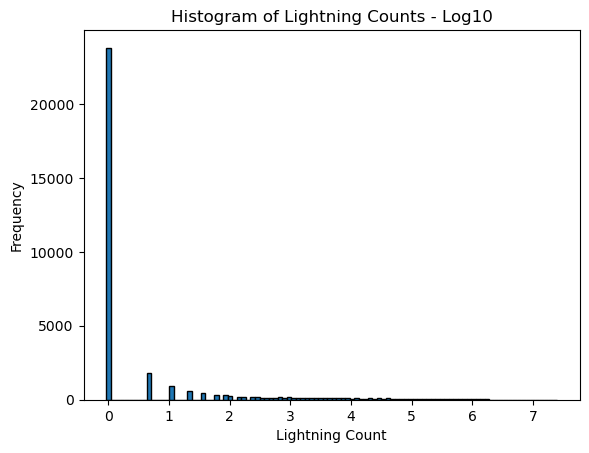

In [16]:
lightning_counts_log = epac_data["log_lightning_count"]

# Create histogram
plt.hist(lightning_counts_log, bins=100, edgecolor="black", align="left")

# Labels and title
plt.xlabel("Lightning Count")
plt.ylabel("Frequency")
plt.title("Histogram of Lightning Counts - Log10")
plt.show()

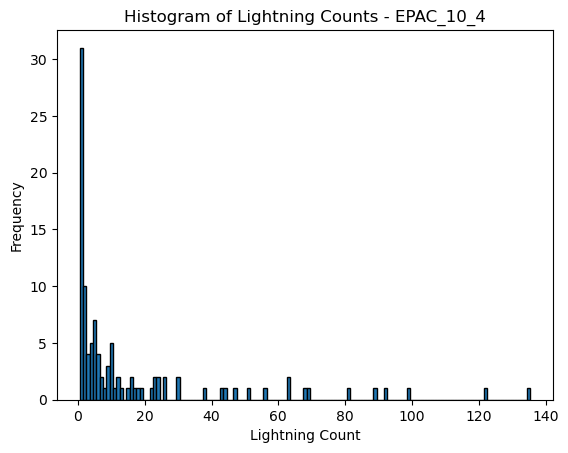

In [5]:
# for one specific TC
epac_10_4 = epac_data.filter(pl.col("storm_code") == "EPAC_10_4")
lightning_counts = epac_10_4["lightning_count"]
# Create histogram
plt.hist(lightning_counts, bins=range(1, max(lightning_counts) + 2), edgecolor="black", align="left")

# Labels and title
plt.xlabel("Lightning Count")
plt.ylabel("Frequency")
plt.title("Histogram of Lightning Counts - EPAC_10_4")
plt.show()

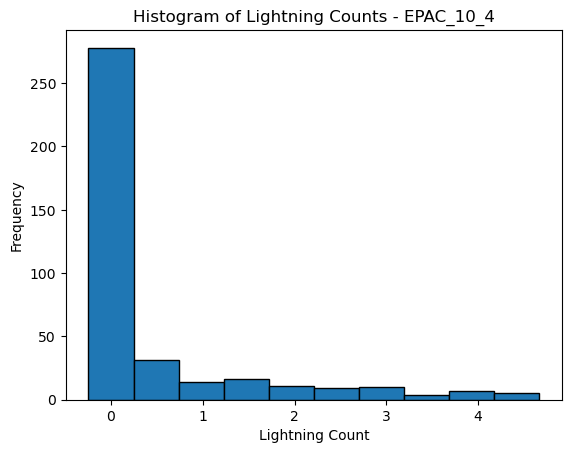

In [10]:
# for one specific TC
epac_10_4 = epac_data.filter(pl.col("storm_code") == "EPAC_10_4")
lightning_counts = epac_10_4["log_lightning_count"]
# Create histogram
plt.hist(lightning_counts, bins=10, edgecolor="black", align="left")

# Labels and title
plt.xlabel("Lightning Count")
plt.ylabel("Frequency")
plt.title("Histogram of Lightning Counts - EPAC_10_4")
plt.show()